In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [38]:
disease_types=['COVID', 'Normal']
data_dir = '/kaggle/input/bruhhh/archive/COVID-19_Radiography_Dataset'
train_dir = os.path.join(data_dir)

In [39]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/COVID-1994.png,0,COVID
1,COVID/COVID-1825.png,0,COVID
2,COVID/COVID-517.png,0,COVID
3,COVID/COVID-532.png,0,COVID
4,COVID/COVID-2272.png,0,COVID


In [40]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Normal/Normal-2726.png,1,Normal
1,Normal/Normal-4235.png,1,Normal
2,COVID/COVID-1758.png,0,COVID
3,COVID/COVID-3063.png,0,COVID
4,Normal/Normal-4441.png,1,Normal


In [41]:
import pandas_profiling as pp
pp.ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

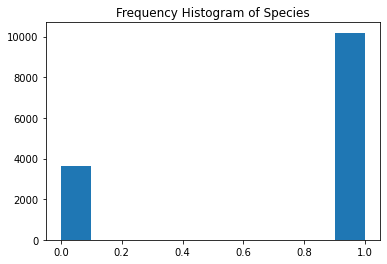

<Figure size 864x864 with 0 Axes>

In [42]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

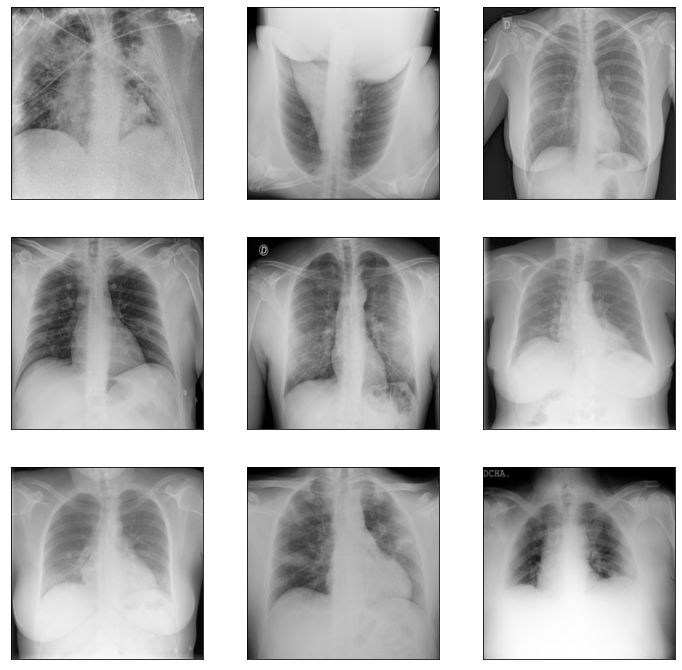

In [43]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)


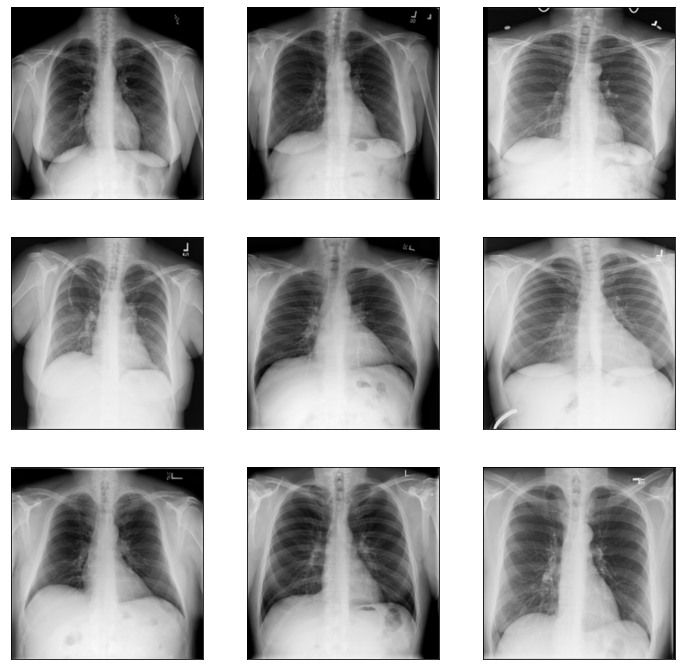

In [44]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Normal', 3, 3)

In [45]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [46]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

13808it [01:47, 128.24it/s]


Train Shape: (13808, 64, 64, 3)


In [47]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(13808, 2)


In [48]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [49]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (11046, 64, 64, 3)
X_val: (2762, 64, 64, 3)
Y_train: (11046, 2)
Y_val: (2762, 2)


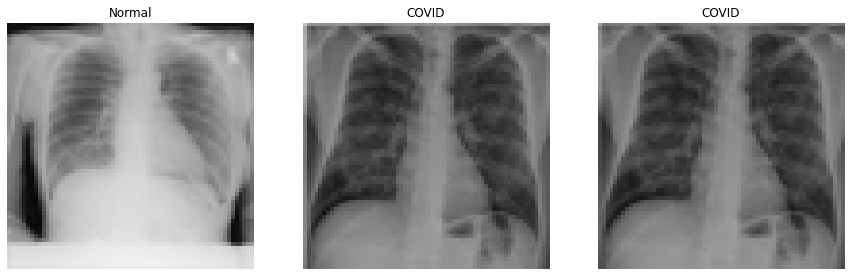

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])


In [69]:
EPOCHS = 50
SIZE=64
N_ch=3

In [57]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [58]:
model = build_resnet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               5245

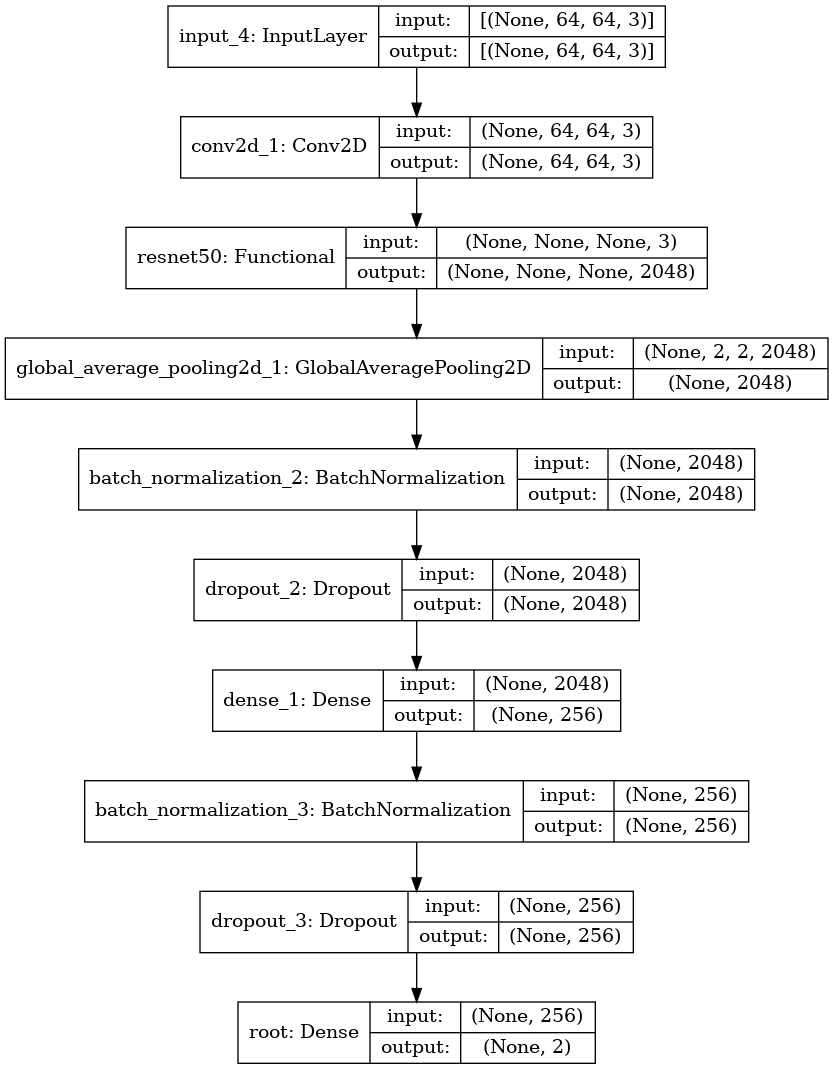

In [59]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 


# Data Augmentation

In [60]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-14 12:35:04.711855: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
172/172 [==============================] - 326s 2s/step - loss: 0.9383 - accuracy: 0.6081 - val_loss: 2.6400 - val_accuracy: 0.2607

Epoch 00001: val_loss improved from inf to 2.64003, saving model to model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
172/172 [==============================] - 314s 2s/step - loss: 0.5381 - accuracy: 0.7556 - val_loss: 0.9486 - val_accuracy: 0.7393

Epoch 00002: val_loss improved from 2.64003 to 0.94863, saving model to model.h5
Epoch 3/50
172/172 [==============================] - 316s 2s/step - loss: 0.3562 - accuracy: 0.8535 - val_loss: 3.1027 - val_accuracy: 0.2607

Epoch 00003: val_loss did not improve from 0.94863
Epoch 4/50
172/172 [==============================] - 313s 2s/step - loss: 0.2869 - accuracy: 0.8891 - val_loss: 5.2715 - val_accuracy: 0.2607

Epoch 00004: val_loss did not improve from 0.94863
Epoch 5/50
172/172 [==============================] - 313s 2s/step - loss: 0.2641 - accuracy: 0.8988 - val_loss: 3.2544 - val_accuracy: 0.2603

Epoch 00005: val_loss did not improve from 0.94863
Epoch 6/50
172/172 [==============================] - 313s 2s/step - loss: 0.2281 - accuracy: 0.9145 - val_loss: 1.8713 - val_accuracy: 0.3349

Epoch 00006: val_loss did not improve from 0.9

In [61]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

87/87 [==============================] - 22s 248ms/step - loss: 0.2277 - accuracy: 0.9236
Final Loss: 0.22773200273513794, Final Accuracy: 0.9236060976982117


Text(0.5, 145.31999999999996, 'Predicted')

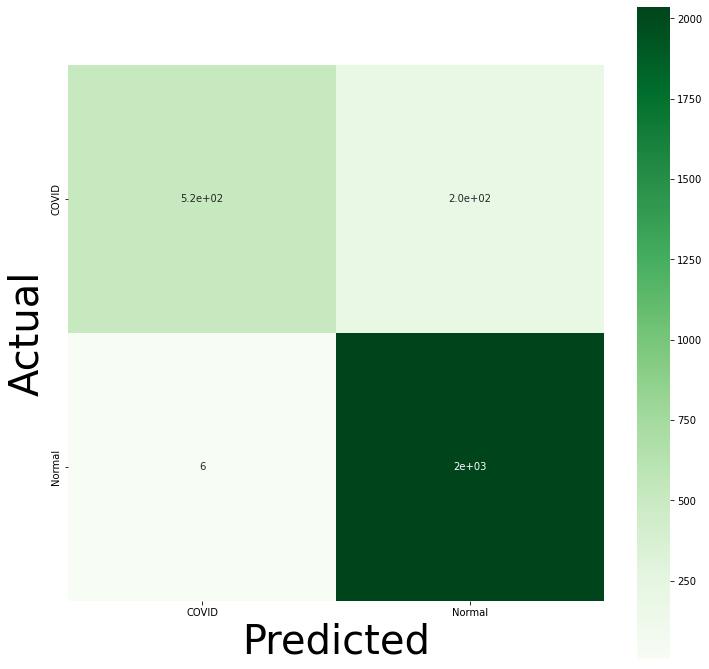

In [62]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

{'validation_data': None,
 'model': <keras.engine.functional.Functional at 0x7ff20c8d5090>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.9382932186126709,
   0.5380998849868774,
   0.35623544454574585,
   0.28691810369491577,
   0.2640801966190338,
   0.22807560861110687,
   0.21675004065036774,
   0.19794760644435883,
   0.19028575718402863,
   0.17225752770900726,
   0.1717505156993866,
   0.1672843098640442,
   0.14723023772239685,
   0.1367214173078537,
   0.1377362757921219,
   0.13146208226680756,
   0.13274864852428436,
   0.11379893124103546,
   0.11951535195112228,
   0.11357431858778,
   0.10801007598638535,
   0.10701239109039307,
   0.10015544295310974,
   0.098927341401577,
   0.09240581840276718,
   0.09426888078451157,
   0.09298980236053467,
   0.08937128633260727,
   0.08965406566858292,
   0.0900004580616951,
   0.08222649991512299,
   0.08081609010696411,
   0.07811225205659866,
   0.08043856918811798,
   0.074491947889328,
   0.0

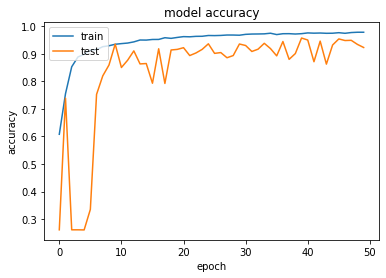

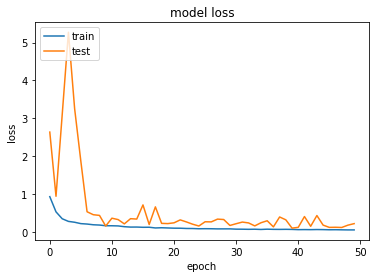

In [63]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


[9.9988639e-01 1.1356809e-04]


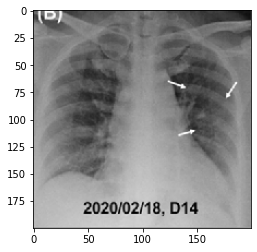

Prediction: Covid


In [83]:
from skimage import io
from keras.preprocessing import image
img = image.load_img('/kaggle/input/bruhhh/archive/COVID-19_Radiography_Dataset/COVID/COVID-1079.png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/kaggle/input/bruhhh/archive/COVID-19_Radiography_Dataset/COVID/COVID-1079.png', grayscale=False, target_size=(200, 200))
disease_class=['Covid','Normal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])